# Car Prediction Assigment notebook


In [289]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import convert_numbers
from sklearn.impute import KNNImputer

read the data from /data folder

In [290]:
car_data = pd.read_csv('../data/data.csv')

take a look at the data shape

In [291]:
car_data.shape

(6864, 16)

see the first 2 rows of the data

In [292]:
car_data.head(2)

,car_name,year,price,color,fuil_type,car_prev_state,license_country,transimission_type,glass_type,motor_power,mileage,passenger_capacity,prev_owners,additional_info,insurance_cost,sell_date
0,كيا اوبتيما,2014.0,100000.0,أبيض عاجي,بنزين,خصوصي,فلسطينية,اوتوماتيك,الكتروني,2000.0,75000.0,4+1,يد اولى,"مُكيّف,إغلاق مركزي,جهاز إنذار,مسجل CD,فتحة سقف...",3090.0,2017-08-16
1,كيا سورينتو,2007.0,60000.0,سكني,ديزل,خصوصي,فلسطينية,نصف اوتوماتيك,الكتروني,2500.0,130000.0,7+1,2,"مُكيّف,إغلاق مركزي,جهاز إنذار,مسجل CD,فتحة سقف...",2740.0,2017-08-16


take a look at the data types of the columns

In [293]:
car_data.dtypes

car_name               object
year                  float64
price                 float64
color                  object
fuil_type              object
car_prev_state         object
license_country        object
transimission_type     object
glass_type             object
motor_power           float64
mileage               float64
passenger_capacity     object
prev_owners            object
additional_info        object
insurance_cost        float64
sell_date              object
dtype: object

draw a histogram for each column to see the distribution of the data and the outliers

array([[<AxesSubplot: title={'center': 'year'}>,
        <AxesSubplot: title={'center': 'price'}>],
       [<AxesSubplot: title={'center': 'motor_power'}>,
        <AxesSubplot: title={'center': 'mileage'}>],
       [<AxesSubplot: title={'center': 'insurance_cost'}>,
        <AxesSubplot: >]], dtype=object)

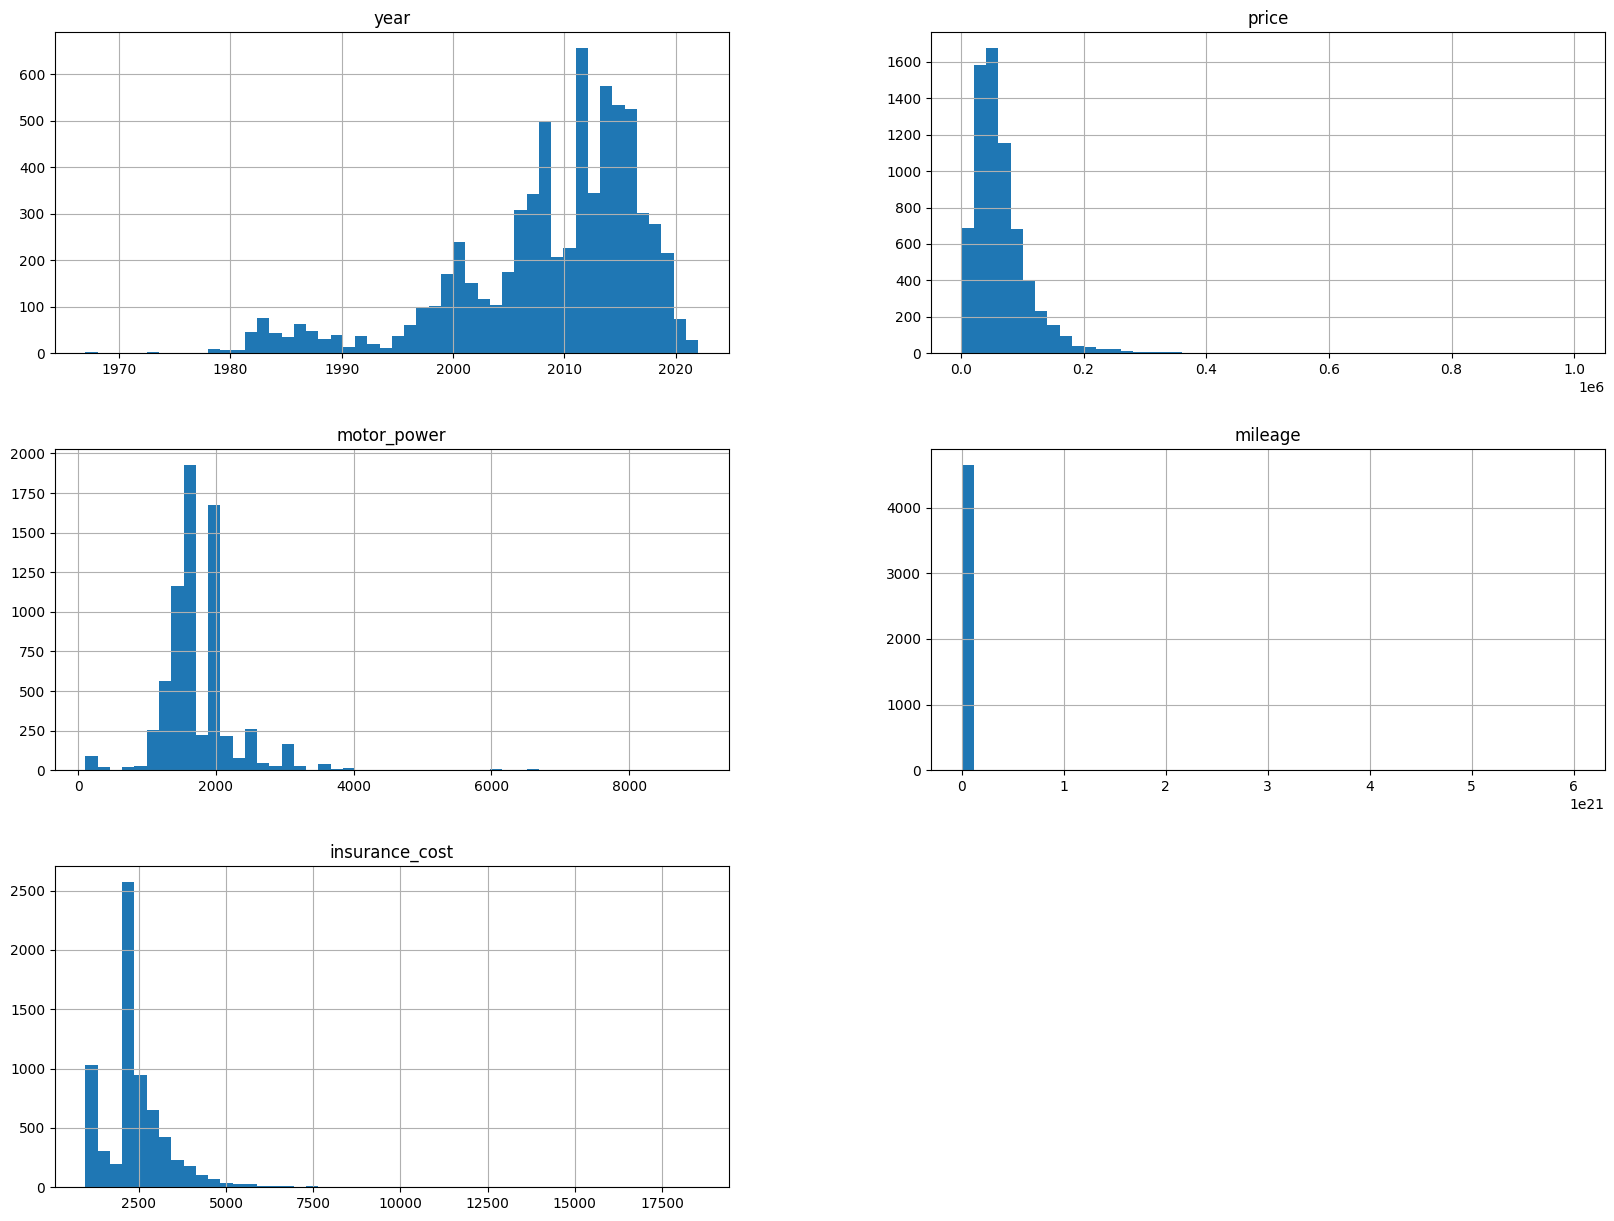

In [294]:
car_data.hist(bins=50, figsize=(20,15))

draw a horizontal bar plot for the categorical columns to see the distribution of the data

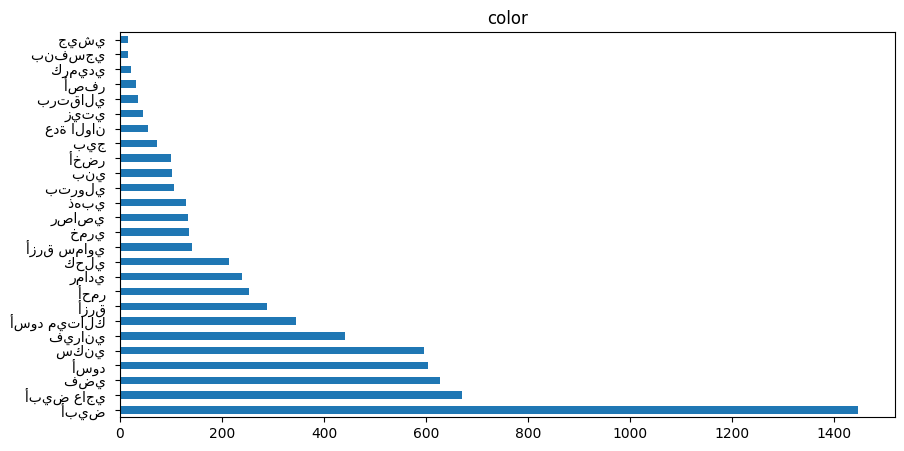

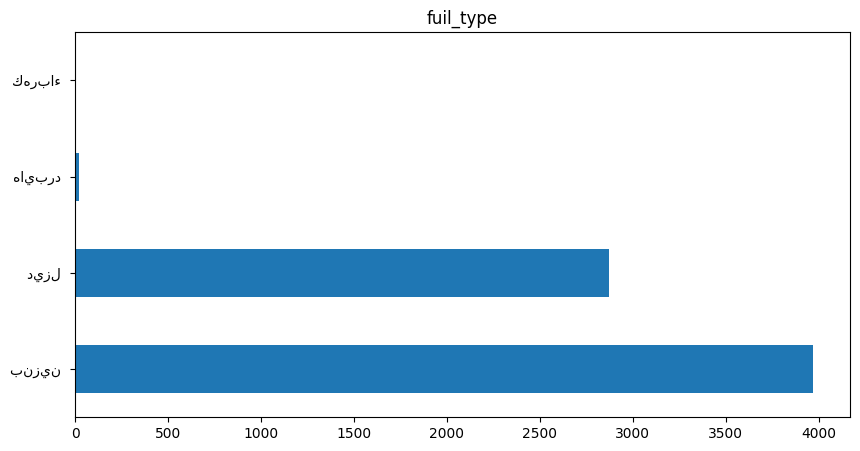

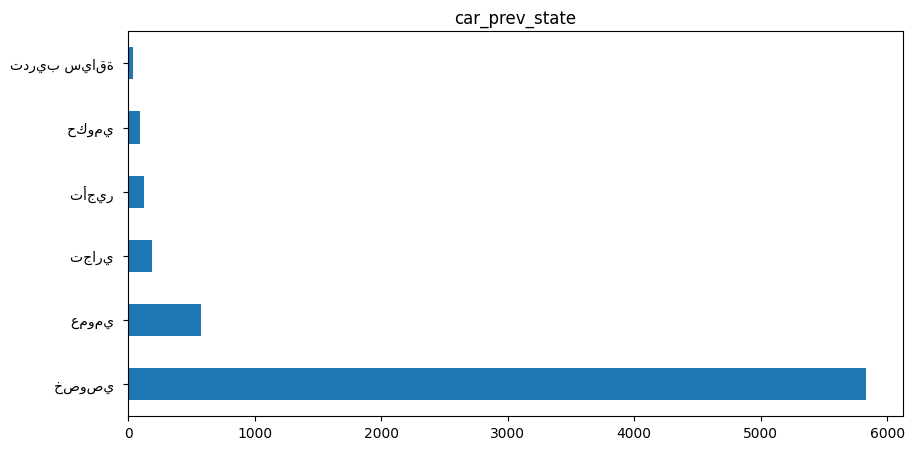

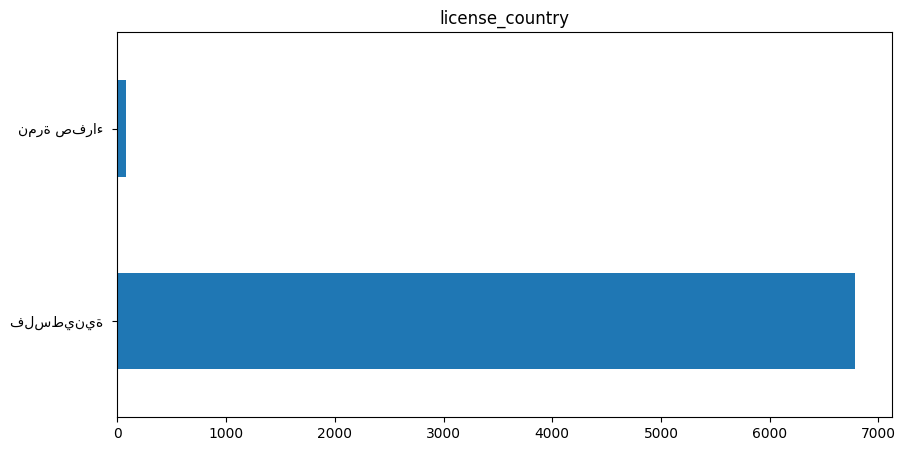

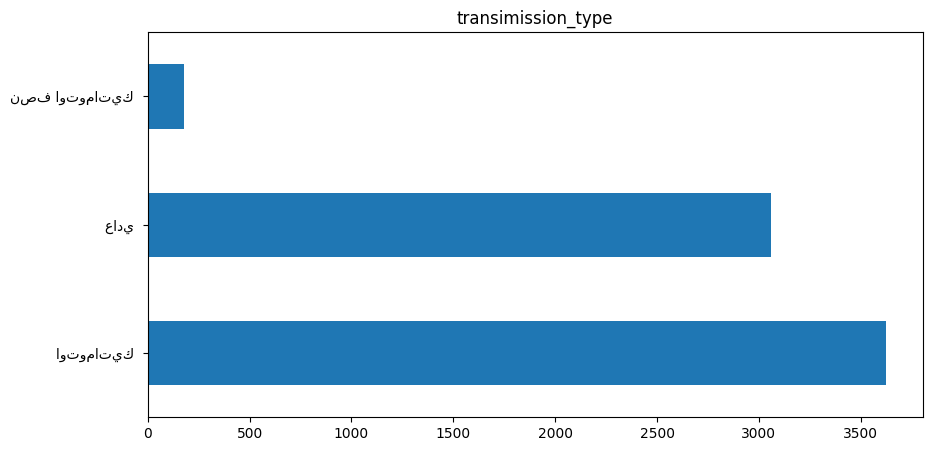

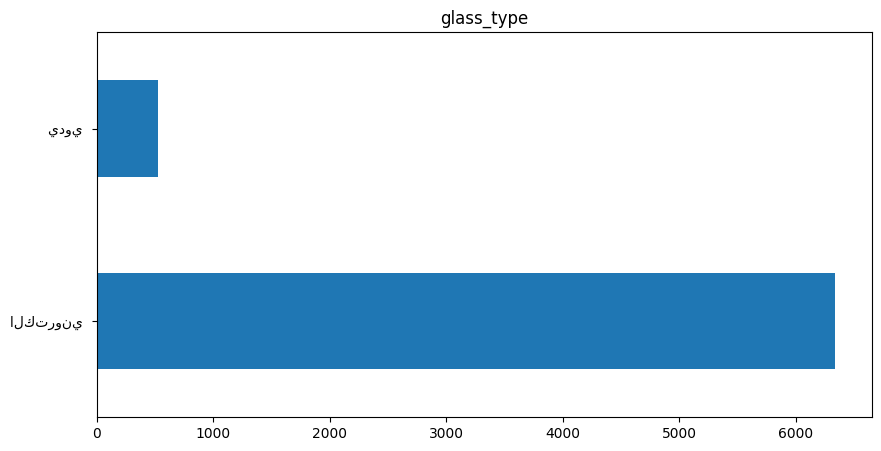

In [295]:
# draw a horizontal bar plot for the categorical columns to see the distribution of the data
def draw_bar_plot(df, col):
    df[col].value_counts().plot(kind='barh', figsize=(10, 5))
    plt.title(col)
    plt.show()
exiclude_columns = ['car_name','prev_owners','additional_info','sell_date','passenger_capacity']
for col in car_data.columns :
    if car_data[col].dtype == 'object' and col not in exiclude_columns:
        draw_bar_plot(car_data, col)

convert the sell_date column to datetime format

In [296]:
# draw a figure to see the sell_date grouped by the year only column distribution
car_data['sell_date'] = pd.to_datetime(car_data['sell_date'])

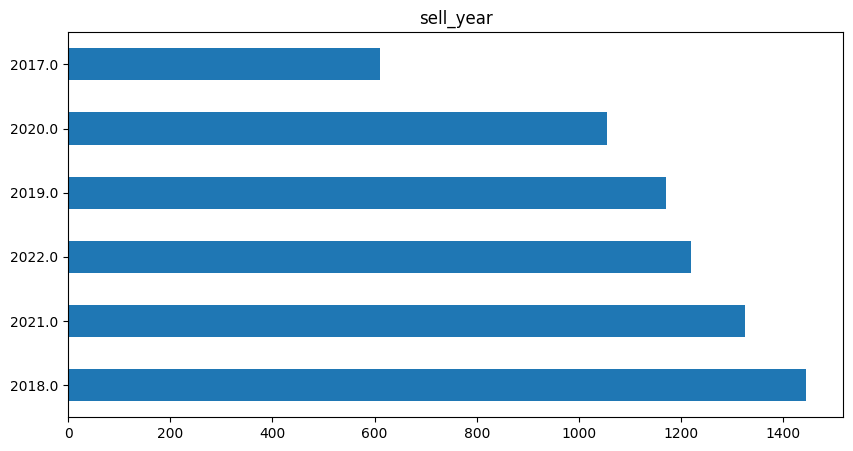

In [297]:
car_data['sell_year'] = car_data['sell_date'].dt.year
car_data['sell_year'].value_counts().plot(kind='barh', figsize=(10, 5))
plt.title('sell_year')
plt.show()

draw a horizontal bar plot for the number of null values in each column

<AxesSubplot: >

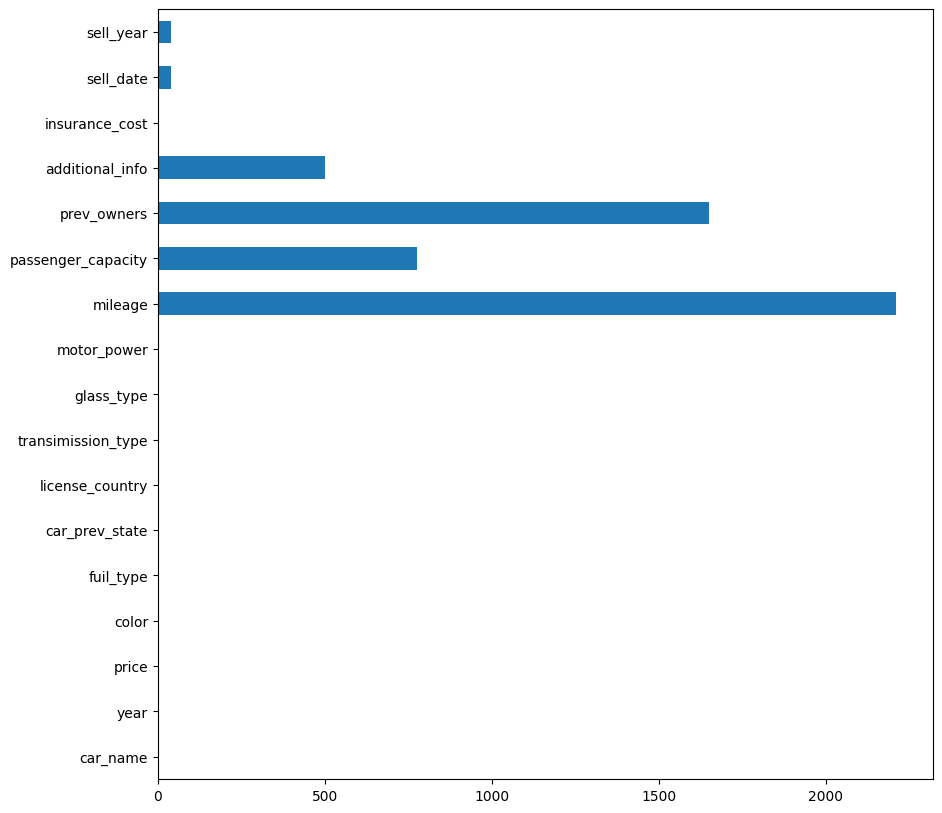

In [298]:
car_data.isnull().sum().plot(kind='barh', figsize=(10, 10))

fill the null values of the additional_info column with empty string ''
becouse if its null it means that there is no additional info

In [299]:
car_data['additional_info'].fillna('', inplace=True)

fill the null values for the sell_date with the ffill method (forward fill) becouse the data is nearly sorted by date and the null values are in the end of the data

In [300]:
car_data['sell_date'].fillna(method='ffill', inplace=True)
# refill the sell_year column after filling the sell_date column
car_data['sell_year'] = car_data['sell_date'].dt.year

function to convert the prev_owner column to string number
theres a few regexs in the function heres the explanation of these regexs <br />

<span style="color:green"> r'أول|اول|1' </span>. <br />
<span style="color:green"> | </span> means or <br />
<span style="color:green"> r'أول|اول|1' </span> means that the string contains أول or اول or 1<br />



<span style="color:green"> [^a-zA-Z0-9\u0600-\u06FF]</span>. <br />
<span style="color:green"> [^] </span> means not <br />
<span style="color:green"> a-zA-Z0-9 </span> means all english numbers and letters <br />
<span style="color:green"> \u0600-\u06FF </span> means all arabic numbers and letters
so the regex means: <span style="color:green">not english numbers and letters and not arabic numbers and letters </span>

In [301]:
def normalize_prev_owner(prev_owner: str)->str or np.nan:
    """ convert the arabic writen discribtion about the prev_owners to a string number

    Args:
        prev_owner (str): the discribtion about the prev_owners

    Returns:
        str : the number of the prev_owners
        np.nan : if the prev_owner is np.nan

    """
    if prev_owner is np.nan:
        return np.nan
    try :
        return str(int(prev_owner))
    except ValueError:
        pass
    if re.search(r'صفر|مش|وارد|مان|احد|يوجد|استيراد|مستورد|شرك|انا', prev_owner):
        return '0'
    if re.search(r'أول|اول|1', prev_owner):
        return '0'
    if re.search(r'ثان|تان|2|اثنان', prev_owner):
        return '0'
    if re.search(r'ثالث|تالث|3|ثلاث|تلات|تالت', prev_owner):
        return '0'
    if re.search(r'رابع|4|اربع|اربعة|اربعه', prev_owner):
        return '0'
    if re.search(r'خامس|5|خمس|خمسة|خمسه', prev_owner):
        return '0'
    if re.search(r'سادس|6|سادسة|سادسه', prev_owner):
        return '0'
    if re.search(r'سابع|7|سابعة|سابعه', prev_owner):
        return '0'
    if re.search(r'ثامن|8|ثامنة|ثامنه', prev_owner):
        return '0'
    if re.search(r'تاسع|9|تاسعة|تاسعه', prev_owner):
        return '0'
    if re.search(r'عاشر|10|عشر|عشرة|عشره', prev_owner):
        return '0'
    if re.search('يد', prev_owner):
        try :
            return str(int(re.search(r'\d+', prev_owner).group())) 
        except AttributeError:
            return np.nan
    if re.search(r'[^a-zA-Z0-9\u0600-\u06FF]', prev_owner):
        return np.nan
    return prev_owner


apply the function to the prev_owner column and convert it to int type 

In [302]:
car_data['prev_owners'] = car_data['prev_owners'].apply(normalize_prev_owner)
car_data['prev_owners'] = pd.to_numeric(car_data['prev_owners'], errors='coerce')
car_data['year'] = car_data['year'].astype(str).str[:-2]

# another possible way to fill the prev_owners column is 
#car_data['prev_owners'].fillna(car_data.groupby('year')['prev_owners'].transform('mean'), inplace=True) #
# but i didn't understand why its working :D ask for it 

function to get the mean of the prev_owner column grouped by the same year of production

In [303]:
def prev_owners_mean(row: pd.Series)->pd.Series:
    """this function is used to fill the prev_owners column with the mean of the prev_owners of the same year

    Args:
        row (pd.Series): the row of the dataframe 
    Returns:
        pd.Series: the row of the dataframe with the filled prev_owners column
    """
    if pd.notnull(row['prev_owners']):
        return row
    year = row['year']
    data = car_data[car_data['year'] == year]
    row['prev_owners'] = data['prev_owners'].mean()
    return row



apply the function to the prev_owner column and drop any remaining null values this could happen if the car is the only one in the year of production

In [304]:
car_data = car_data.apply(prev_owners_mean, axis=1)
car_data = car_data[car_data['prev_owners'].notna()] 

this function takes the string (a+b) format and return the result of a+b  (a and b may be a arabic numbers so we need to convert them to english numbers first)<br />
theres a regex in the function heres the explanation of the regex <br />
the regex is: <span style="color:green"> [^a-zA-Z0-9\u0600-\u06FF]</span>. <br />
<span style="color:green"> [^] </span> means not <br />
<span style="color:green"> a-zA-Z0-9 </span> means all english numbers and letters <br />
<span style="color:green"> \u0600-\u06FF </span> means all arabic numbers and letters
so the regex means: <span style="color:green">not english numbers and letters and not arabic numbers and letters </span>

In [305]:
def arabic_to_english(equation: str)->str or np.nan:
    if pd.isnull(equation):
        return equation
    equation = equation.strip()
    equation = re.sub(r'[^a-zA-Z0-9\u0600-\u06FF]', '', equation)
    equation = convert_numbers.arabic_to_english(equation)
    
    equation = sum([ int(i) for i in equation])
    return equation



apply the function to the passenger_capacity column

In [306]:
car_data['passenger_capacity'] = car_data['passenger_capacity'].apply(arabic_to_english)

to handle the missing values of the passenger_capacity column we will use the KNNImputer from sklearn.impute </br >
the KNNImputer will impute the missing values by using the k nearest neighbors found in the dataset  </br >
the reason we use the KNNImputer is becouse the KNN is based on the distance of the k nearest and this value is most likely to be the same as the similar cars </br > 

In [311]:
imputer = KNNImputer(n_neighbors=5)
car_data['passenger_capacity'] = imputer.fit_transform(car_data[['passenger_capacity']])
car_data['passenger_capacity'] = car_data['passenger_capacity'].astype(int)

this function replacing the missing value of mile_age by the mean of the mile_age grouped by the same year of production </br>
becouse all the cars in the same year of production will likely have the same mile_age or something close to it </br>

In [308]:
def mile_age_mean(row: pd.Series)->pd.Series:
    """this function is used to fill the mileage column with the mean of the mileage of the same year"""
    if pd.notnull(row['mileage']):
        return row
    year = row['year']
    data = car_data[car_data['year'] == year]
    row['mileage'] = data['mileage'].mean()
    return row

In [312]:
car_data = car_data.apply(mile_age_mean, axis=1)
car_data = car_data[car_data['mileage'].notna()]

# Noisy  Data and Outliers
تعبت حلو عني